In [1]:
from __future__ import division

import os
import itertools
import math
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import matplotlib.pylab as plt

from learning2learn.wrangle import synthesize_data
from learning2learn.wrangle import get_train_test_parameters
from learning2learn.wrangle import build_train_set_bits
from learning2learn.wrangle import build_test_trials_o1_bits 
from learning2learn.wrangle import build_test_trials_o2_bits
from learning2learn.util import train_test_split
from learning2learn.util import train_model
from learning2learn.util import evaluate_generalization
from learning2learn.util import get_hidden_representations
from learning2learn.util import similarity
from learning2learn.models import simple_mlp

/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
paper_folder = '../../cogsci-paper/'

In [36]:
nb_categories = 4
nb_exemplars = 3
nb_test_trials = 1000
batch_size = min(32, int(np.floor(nb_categories*nb_exemplars/5)))

In [37]:
np.random.seed(0)
(shape_set_train, shape_set_test), \
(color_set_train, color_set_test), \
(texture_set_train, texture_set_test) = \
        get_train_test_parameters(images=False, nb_bits=20)
df_train, labels = synthesize_data(nb_categories, nb_exemplars)
labels = labels.values
ohe = OneHotEncoder(sparse=False)
Y_train = ohe.fit_transform(labels.reshape(-1, 1))

In [38]:
X_train = build_train_set_bits(df_train, shape_set_train, color_set_train, texture_set_train)

In [39]:
X_test_o1 = build_test_trials_o1_bits(
    df_train, shape_set_train, shape_set_test, color_set_train,
    color_set_test, texture_set_train, texture_set_test,
    nb_trials=nb_test_trials
)

In [40]:
X_test_o2 = build_test_trials_o2_bits(
    shape_set_test, color_set_test, texture_set_test,
    nb_trials=nb_test_trials
)

In [48]:
model = simple_mlp(nb_in=60, nb_classes=nb_categories)

In [53]:
# Quick side experiment here... let's see what frequencies the random model 
# chooses shape, color and texture

def evaluate_generalization1(model, X, layer_num, batch_size=32):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X) % 4 == 0
    X_p = get_hidden_representations(model, X, layer_num=layer_num,
                                     batch_size=batch_size)
    results = {0:0, 1:0, 2:0}
    for i in range(int(len(X) / 4)):
        scores = np.zeros(3)
        scores[0] = similarity(X_p[4*i], X_p[4*i+1]) # shape match score
        scores[1] = similarity(X_p[4*i], X_p[4*i+2]) # color match score
        scores[2] = similarity(X_p[4*i], X_p[4*i+3]) # texture match score
        match = np.argmax(scores)
        # if multiple scores were max, then argmax chooses first index... make
        # sure that didn't happen.
        others = list(range(3))
        others.remove(match)
        if (scores[match] == scores[others[0]] or
                    scores[match] == scores[others[1]]):
            match = np.random.choice(range(3), 1)[0]
        results[match] += 1

    # Return the percentage of times we were correct
    return results[0]/float(len(X)/4), results[1]/float(len(X)/4), results[2]/float(len(X)/4)

In [54]:
score_s, score_c, score_t = evaluate_generalization1(
    model, X_test_o2, layer_num=-3,
    batch_size=128
)
print('Score shape: %0.4f' % score_s)
print('Score color: %0.4f' % score_c)
print('Score texture: %0.4f' % score_t)

Score shape: 0.3020
Score color: 0.3680
Score texture: 0.3300


In [59]:
scores_s = np.zeros(50)
scores_c = np.zeros(50)
scores_t = np.zeros(50)
for i in range(50):
    model = simple_mlp(nb_in=60, nb_classes=nb_categories)
    scores_s[i], scores_c[i], scores_t[i] = evaluate_generalization1(
        model, X_test_o2, layer_num=-3,
        batch_size=128
    )

In [60]:
print('Score shape: %0.4f' % scores_s.mean())
print('Score color: %0.4f' % scores_c.mean())
print('Score texture: %0.4f' % scores_t.mean())

Score shape: 0.3661
Score color: 0.3317
Score texture: 0.3022


In [58]:
print('Score shape: %0.4f' % scores_s.mean())
print('Score color: %0.4f' % scores_c.mean())
print('Score texture: %0.4f' % scores_t.mean())

Score shape: 0.3682
Score color: 0.3238
Score texture: 0.3080


In [42]:
weights_file = '../data/temp.h5'
if os.path.isfile(weights_file):
    os.remove(weights_file)
checkpoint = ModelCheckpoint(
    weights_file,
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    period=2
)
train_model(
    model, X_train, Y_train, epochs=200,
    validation_data=None, batch_size=batch_size,
    checkpoint=checkpoint, burn_period=100
)
model.load_weights(weights_file)

Epoch 1/100
12/12 [==============================] - 0s 18ms/step - loss: 1.9113 - acc: 0.3333
Epoch 2/100
12/12 [==============================] - 0s 664us/step - loss: 1.6943 - acc: 0.3333
Epoch 3/100
12/12 [==============================] - 0s 576us/step - loss: 1.5458 - acc: 0.4167
Epoch 4/100
12/12 [==============================] - 0s 819us/step - loss: 1.4335 - acc: 0.5833
Epoch 5/100
12/12 [==============================] - 0s 599us/step - loss: 1.3571 - acc: 0.8333
Epoch 6/100
12/12 [==============================] - 0s 620us/step - loss: 1.2589 - acc: 0.9167
Epoch 7/100
12/12 [==============================] - 0s 568us/step - loss: 1.1800 - acc: 0.9167
Epoch 8/100
12/12 [==============================] - 0s 713us/step - loss: 1.0983 - acc: 1.0000
Epoch 9/100
12/12 [==============================] - 0s 704us/step - loss: 1.0412 - acc: 1.0000
Epoch 10/100
12/12 [==============================] - 0s 825us/step - loss: 0.9739 - acc: 0.9167
Epoch 11/100
12/12 [====================

12/12 [==============================] - 0s 592us/step - loss: 0.0260 - acc: 1.0000
Epoch 70/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0263 - acc: 1.0000
Epoch 71/100
12/12 [==============================] - 0s 596us/step - loss: 0.0271 - acc: 1.0000
Epoch 72/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0253 - acc: 1.0000
Epoch 73/100
12/12 [==============================] - 0s 633us/step - loss: 0.0256 - acc: 1.0000
Epoch 74/100
12/12 [==============================] - 0s 762us/step - loss: 0.0265 - acc: 1.0000
Epoch 75/100
12/12 [==============================] - 0s 603us/step - loss: 0.0255 - acc: 1.0000
Epoch 76/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0253 - acc: 1.0000
Epoch 77/100
12/12 [==============================] - 0s 729us/step - loss: 0.0248 - acc: 1.0000
Epoch 78/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0243 - acc: 1.0000
Epoch 79/100
12/12 [==============================]

In [43]:
score = evaluate_generalization(
    model, X_test_o2, layer_num=-3,
    batch_size=128
)
print('Score O2: %0.4f' % score)

Score O2: 0.9210


In [44]:
np.random.seed(0)
s1, s2 = np.random.choice(range(len(shape_set_test)), 2, replace=False)
c1, c2 = np.random.choice(range(len(color_set_test)), 2, replace=False)
t1, t2 = np.random.choice(range(len(texture_set_test)), 2, replace=False)
shape1, shape2 = shape_set_test[s1], shape_set_test[s2]
color1, color2 = color_set_test[c1], color_set_test[c2]
texture1, texture2 = texture_set_test[t1], texture_set_test[t2]

In [45]:
def modify_feature(feature, nb_bits):
    assert type(nb_bits) == int and nb_bits >=0 and nb_bits <= 20
    np.random.seed(0)
    ix = np.random.permutation(range(20))
    feature_p = np.copy(feature)
    for i in ix[:nb_bits]:
        feature_p[i] = np.abs(feature[i] - 1)
    
    return feature_p

In [46]:
from sklearn.linear_model import LinearRegression

def plot_results(similarities, feature):
    # first compute the LR fit
    x_grid = np.arange(21).reshape(-1,1)
    lr = LinearRegression()
    lr.fit(x_grid, similarities.reshape(-1,1))
    y_grid = lr.predict(x_grid)
    
    assert feature in ['shape', 'color', 'texture']
    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.scatter(range(21), similarities)
    ax.plot(x_grid, y_grid, '--', color='grey', 
            label='OLS fit (coef: %0.4f)' % lr.coef_[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0,1.1)
    ax.set_xlabel('# of %s bits flipped' % feature, fontsize=18)
    ax.set_ylabel('Model similarity', fontsize=18)
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_yticklabels(np.linspace(0,1,6), fontsize=15)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xticklabels(np.arange(0,21,5), fontsize=15)
    plt.legend(loc='lower right', fontsize=18)
    plt.suptitle('Bias strength vs. %s similarity' % feature, fontsize=18)
    plt.show()

# shape tests first, others_constant=True

In [14]:
sample1 = np.hstack((shape1, color1, texture1))

In [16]:
# sanity check
features = get_hidden_representations(
    model=model,
    X=np.vstack((sample1, sample1)),
    layer_num=-3,
    batch_size=2
)
print('similarity: %0.4f' % similarity(features[0], features[1]))

similarity: 1.0000


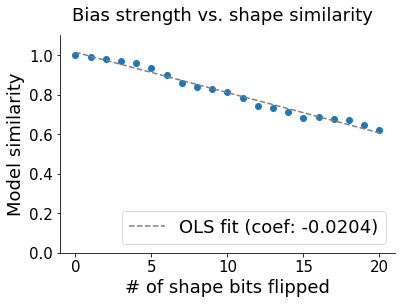

In [17]:
similarities = np.zeros(21)
for i in range(21):
    shape1_p = modify_feature(shape1, nb_bits=i)
    sample2 = np.hstack((shape1_p, color1, texture1))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
#     print('# flipped: %i' % i)
#     print('similarity: %0.4f\n' % similarities[i])
plot_results(similarities, 'shape')

# Now try color, others_constant=True

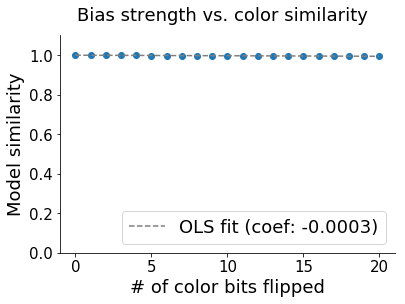

In [18]:
similarities = np.zeros(21)
for i in range(21):
    color1_p = modify_feature(color1, nb_bits=i)
    sample2 = np.hstack((shape1, color1_p, texture1))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'color')

# texture, others_constant=True

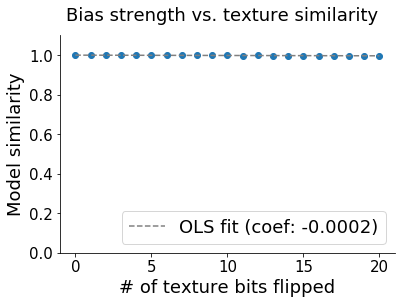

In [19]:
similarities = np.zeros(21)
for i in range(21):
    texture1_p = modify_feature(texture1, nb_bits=i)
    sample2 = np.hstack((shape1, color1, texture1_p))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'texture')

In [ ]:
# Place all 3 results for others_constant=False on the same graph

In [22]:
similarities_shape = np.zeros(21)
similarities_color = np.zeros(21)
for i in range(21):
    shape1_p = modify_feature(shape1, nb_bits=i)
    color1_p = modify_feature(color1, nb_bits=i)
    sample2_shape = np.hstack((shape1_p, color1, texture1))
    sample2_color = np.hstack((shape1, color1_p, texture1))
    features_shape = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2_shape)),
        layer_num=-3,
        batch_size=2
    )
    features_color = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2_color)),
        layer_num=-3,
        batch_size=2
    )
    similarities_shape[i] = similarity(features_shape[0], features_shape[1])
    similarities_color[i] = similarity(features_color[0], features_color[1])

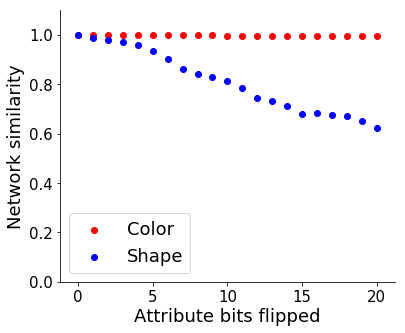

In [47]:
save = False
# first compute the LR fit
x_grid = np.arange(21).reshape(-1,1)
lr_shape = LinearRegression()
lr_color = LinearRegression()
lr_shape.fit(x_grid, similarities_shape.reshape(-1,1))
lr_color.fit(x_grid, similarities_color.reshape(-1,1))
y_grid_shape = lr_shape.predict(x_grid)
y_grid_color = lr_color.predict(x_grid)
    
fig, ax = plt.subplots(1, figsize=(6,5))
ax.scatter(range(21), similarities_color, color='red', label='Color')
ax.scatter(range(21), similarities_shape, color='blue', label='Shape')
#ax.plot(x_grid, y_grid_shape, '--', color='blue')
#ax.plot(x_grid, y_grid_color, '--', color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,1.1)
ax.set_xlabel('Attribute bits flipped', fontsize=18)
ax.set_ylabel('Network similarity', fontsize=18)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(np.linspace(0,1,6), fontsize=15)
ax.set_xticks(np.arange(0,21,5))
ax.set_xticklabels(np.arange(0,21,5), fontsize=15)
plt.legend(loc='lower left', fontsize=18)
#plt.suptitle('Bias strength vs. feature similarity', fontsize=18)
if save:
    plt.savefig(
        os.path.join(paper_folder, 'figures/mlp_parametric.pdf'),
        format='pdf',
        bbox_inches='tight'
    )
else:
    plt.show()

In [26]:
def run_experiment(seed, save=False):
    np.random.seed(seed)
    s1, s2 = np.random.choice(range(len(shape_set_test)), 2, replace=False)
    c1, c2 = np.random.choice(range(len(color_set_test)), 2, replace=False)
    t1, t2 = np.random.choice(range(len(texture_set_test)), 2, replace=False)
    shape1, shape2 = shape_set_test[s1], shape_set_test[s2]
    color1, color2 = color_set_test[c1], color_set_test[c2]
    texture1, texture2 = texture_set_test[t1], texture_set_test[t2]
    # build the baseline object
    sample1 = np.hstack((shape1, color1, texture1))
    # proceed with experiment
    similarities_shape = np.zeros(21)
    similarities_color = np.zeros(21)
    similarities_texture = np.zeros(21)
    for i in range(21):
        shape1_p = modify_feature(shape1, nb_bits=i)
        color1_p = modify_feature(color1, nb_bits=i)
        texture1_p = modify_feature(texture1, nb_bits=i)
        sample2_shape = np.hstack((shape1_p, color2, texture2))
        sample2_color = np.hstack((shape2, color1_p, texture2))
        sample2_texture = np.hstack((shape2, color2, texture1_p))
        features_shape = get_hidden_representations(
            model=model,
            X=np.vstack((sample1,sample2_shape)),
            layer_num=-3,
            batch_size=2
        )
        features_color = get_hidden_representations(
            model=model,
            X=np.vstack((sample1,sample2_color)),
            layer_num=-3,
            batch_size=2
        )
        features_texture = get_hidden_representations(
            model=model,
            X=np.vstack((sample1,sample2_texture)),
            layer_num=-3,
            batch_size=2
        )
        similarities_shape[i] = similarity(features_shape[0], features_shape[1])
        similarities_color[i] = similarity(features_color[0], features_color[1])
        similarities_texture[i] = similarity(features_texture[0], features_texture[1])
        
    # first compute the LR fit
    x_grid = np.arange(21).reshape(-1,1)
    lr_shape = LinearRegression()
    lr_color = LinearRegression()
    lr_shape.fit(x_grid, similarities_shape.reshape(-1,1))
    lr_color.fit(x_grid, similarities_color.reshape(-1,1))
    y_grid_shape = lr_shape.predict(x_grid)
    y_grid_color = lr_color.predict(x_grid)

    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.scatter(range(21), similarities_shape, color='blue', 
               label='Shape. OLS coeff: %0.4f' % lr_shape.coef_[0])
    ax.scatter(range(21), similarities_color, color='red', 
               label='Color. OLS coeff: %0.4f' % lr_color.coef_[0])
    ax.plot(x_grid, y_grid_shape, '--', color='blue')
    ax.plot(x_grid, y_grid_color, '--', color='red')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0,1.1)
    ax.set_xlabel('Number of feature bits flipped', fontsize=18)
    ax.set_ylabel('Model similarity', fontsize=18)
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_yticklabels(np.linspace(0,1,6), fontsize=15)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xticklabels(np.arange(0,21,5), fontsize=15)
    plt.legend(loc='lower right', fontsize=18)
    plt.suptitle('Bias strength vs. feature similarity', fontsize=18)
    if save:
        plt.savefig(
            os.path.join(paper_folder, 'figures/mlp_parametric.pdf'),
            format='pdf',
            bbox_inches='tight'
        )
    else:
        plt.show()

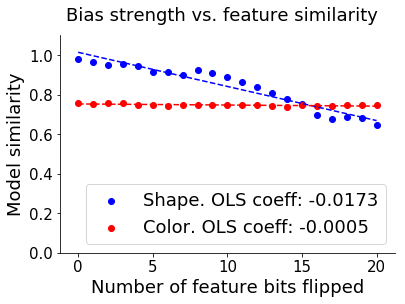

In [27]:
run_experiment(1, save=False)

seed: 0


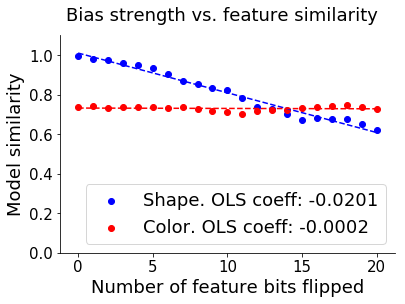

seed: 1


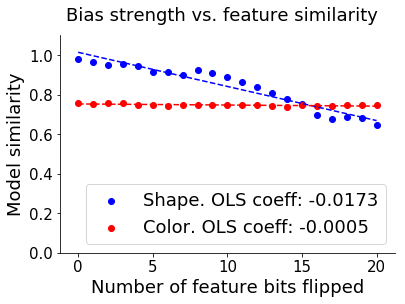

seed: 2


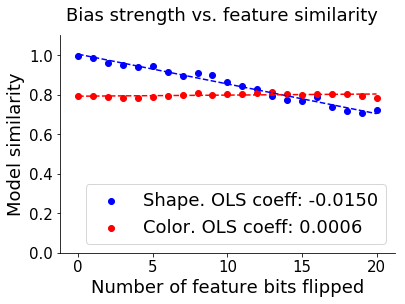

seed: 3


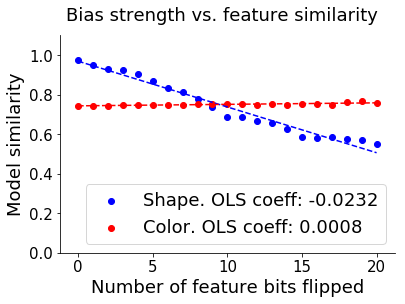

seed: 4


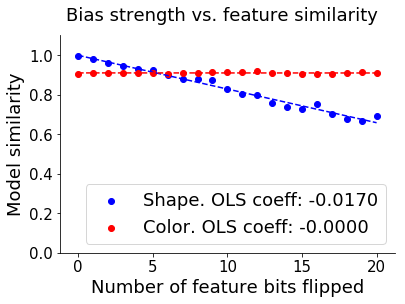

seed: 5


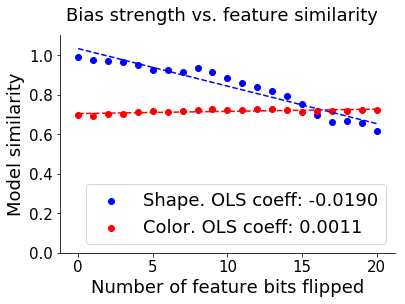

seed: 6


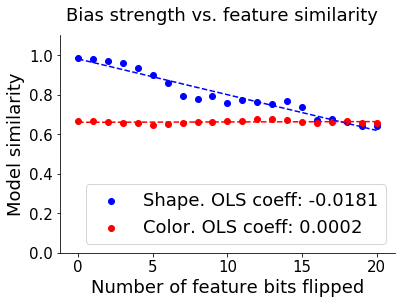

seed: 7


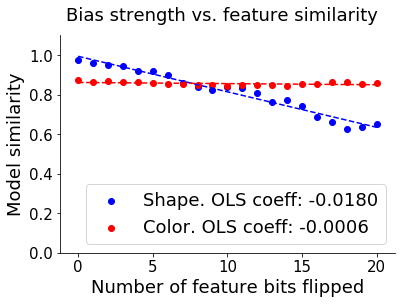

seed: 8


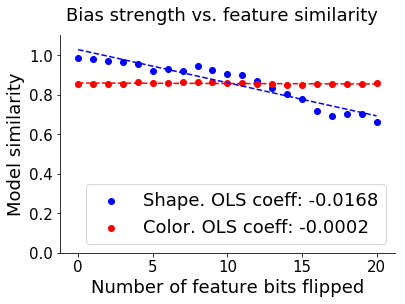

seed: 9


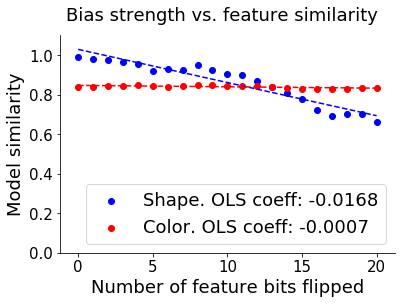

In [28]:
for i in range(10):
    print('seed: %i' % i)
    run_experiment(i, save=False)